In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
from esem import gp_model
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

2024-03-05 19:45:44.223286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 19:45:44.223384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 19:45:44.241718: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 19:45:44.286471: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 19:45:45.619779: W tensorflow/compiler/tf2

### Prepare data

In [2]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG"]

In [3]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_pr = create_predictdand_data(train_files)['pr90'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
pr_truth = Y_test["pr90"].mean('member')

In [4]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_pr = y_train_pr[~nan_train_mask]
assert len(X_train) == len(y_train_pr)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
pr_truth = pr_truth[~nan_test_mask]

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_pr_mean, train_pr_std = y_train_pr.mean(), y_train_pr.std()
y_train_pr = (y_train_pr - train_pr_mean) / train_pr_std

# Scale pr
pr_truth *= 86400

### Prepare model

In [7]:
import gpflow
from gpflow.utilities import to_default_float
from gpflow.optimizers import Scipy
from gpflow.mean_functions import Constant
from gpflow.kernels import Matern52
from gpflow.utilities import print_summary

In [8]:
def create_feature_extractor(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_dim,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='linear'),
        tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float64))
    ])
    return model


In [9]:
class DeepKernel(gpflow.kernels.Kernel):
    def __init__(self, feature_extractor, base_kernel, input_dim):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.base_kernel = base_kernel
        self.input_dim = input_dim

    def K(self, X, X2=None):
        # Transform X and X2 using the neural network
        X_transformed = self.feature_extractor(X)
        X2_transformed = self.feature_extractor(X2) if X2 is not None else X2
        # Compute the kernel using the transformed inputs
        return self.base_kernel(X_transformed, X2_transformed)

    def K_diag(self, X):
        X_transformed = self.feature_extractor(X)
        return self.base_kernel.K_diag(X_transformed)


In [10]:
# Define the neural network feature extractor
input_dim = X_train.shape[1]  # Number of features in X
output_dim = 24
feature_extractor = create_feature_extractor(input_dim, output_dim)

# Freeze the neural network layers to make them non-trainable in GPflow's optimization process
for layer in feature_extractor.layers:
    layer.trainable = True

# Define the base kernel and the deep kernel
kernel_CO2 = Matern52(active_dims=[0, 1], variance=1.0, lengthscales=2 * [1.])
kernel_CH4 = Matern52(active_dims=[2, 3], variance=1.0, lengthscales=2 * [1.])
kernel_BC = Matern52(active_dims=[4, 5, 6, 7, 8, 9, 10, 11, 12, 13], variance=1.0, lengthscales=10 * [1.])
kernel_SO2 = Matern52(active_dims=[14, 15, 16, 17, 18, 19, 20, 21, 22, 23], variance=1.0, lengthscales=10 * [1.])

kernel_matern12 = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

base_kernel = kernel_matern12
deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

# Mean Function
mean_function = Constant()

# Create the GP model
model = gpflow.models.GPR(data=(X_train.astype(float), y_train_pr.astype(float)), kernel=deep_kernel, mean_function=mean_function)

# Compile the TensorFlow model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def optimization_step():
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        loss = -model.log_marginal_likelihood()
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

2024-03-05 19:45:59.280177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79084 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0


In [11]:
tolerance = 1e-6  # Define tolerance
patience = 10  # Define patience

# Initialize variables for early stopping mechanism
best_loss = float('inf')
patience_counter = 0
max_iterations = 5000

# Training loop
for iteration in range(max_iterations):  # Number of optimization steps
    loss = optimization_step()

    # Early stopping logic
    if best_loss - loss < tolerance:
        patience_counter += 1
    else:
        patience_counter = 0
        best_loss = loss

    if patience_counter >= patience:
        print(f"Stopping training after {iteration + 1} iterations due to convergence.")
        break

2024-03-05 19:46:07.767298: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0xc0f5f00
2024-03-05 19:46:07.930973: I external/local_xla/xla/service/service.cc:168] XLA service 0x14ec311f4220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-05 19:46:07.931016: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-03-05 19:46:07.949246: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-05 19:46:07.989072: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1709693168.083873   39751 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Stopping training after 43 iterations due to convergence.


### Predict on testing set

In [12]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_pr_std + train_pr_mean
posterior_std = np.sqrt(standard_posterior_var) * train_pr_std

In [13]:
# put output back into xarray format for calculating RMSE/plotting
posterior_pr = np.reshape(posterior_mean, [86, 96, 144])
posterior_pr_std = np.reshape(posterior_std, [86, 96, 144])

posterior_pr_data = xr.DataArray(posterior_pr, dims=pr_truth.dims, coords=pr_truth.coords)
posterior_pr_std_data = xr.DataArray(posterior_pr_std, dims=pr_truth.dims, coords=pr_truth.coords)

In [14]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(pr_truth[35], posterior_pr_data[35])}")
print(f"RMSE at 2100: {get_rmse(pr_truth[85], posterior_pr_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(pr_truth[30:41], posterior_pr_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr_truth[75:], posterior_pr_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr_truth[35:], posterior_pr_data[35:]).mean()}")

RMSE at 2050: 1.3799410010117135
RMSE at 2100: 3.390856929787882
RMSE 2045-2055: 1.7031311368864464
RMSE 2090-2100: 2.8337156779036485
RMSE 2050-2100: 2.121909197194202


[Text(0.5, 1.0, 'Difference')]

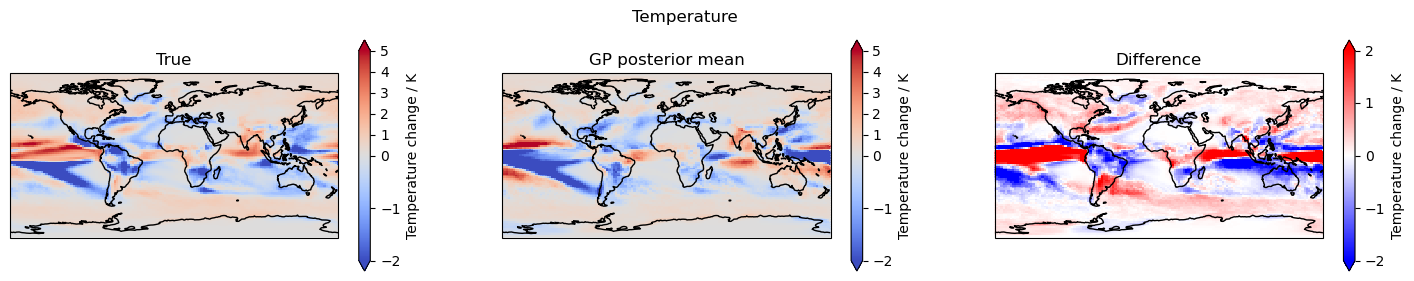

In [15]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_pr_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr_truth - posterior_pr_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [16]:
def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])

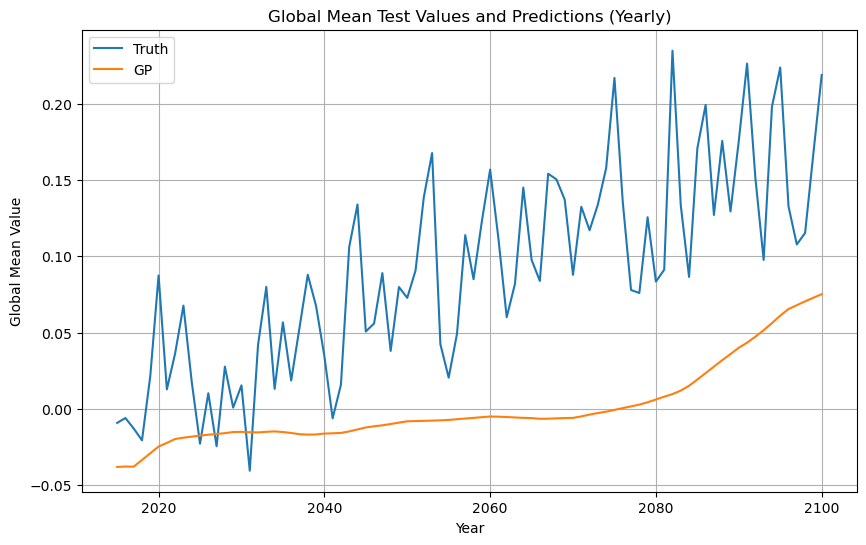

In [17]:
# t = xr.open_dataarray('climatebench-gp-posterior-mean-pr-test-2019-2100.nc')
plt.figure(figsize=(10, 6))
global_mean(pr_truth).plot(label="Truth")
global_mean(posterior_pr_data).plot(label='GP')
# global_mean(t).plot(label='from repo')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

## Hyperparams Tuning

In [18]:
from ray import tune, train
from ray.tune.search.hyperopt import HyperOptSearch
from gpflow.kernels import Matern12, Matern32, Matern52, SquaredExponential, RationalQuadratic, Cosine, Periodic, Polynomial, ArcCosine, Exponential
import keras
import math
from gpflow.mean_functions import Constant
from xskillscore import rmse
from ray.tune import CLIReporter
import ray

In [19]:
ray.init(num_cpus=1, num_gpus=1)

2024-03-05 19:46:25,625	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.9.18
Ray version:,2.9.3


In [20]:
def get_rmse(truth, pred):
    return np.sqrt(((truth-pred)**2))

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).mean(['lat', 'lon'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.lat))
    return ds.weighted(weights).sum(['lat', 'lon'])

weights = np.cos(np.deg2rad(pr_truth.lat)).expand_dims(lon=144).assign_coords(lon=pr_truth.lon)
    
def TNRMSE(truth, pred, Yearslice=slice(2080, None)):
    # R2E Score
    R2E = rmse(
        global_mean(truth.sel(time=Yearslice)), 
        global_mean(pred.sel(time=Yearslice))
    ).data/np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    # NRMSE score
    NRMSE = rmse(
        truth.sel(time=Yearslice).mean('time'), 
        pred.sel(time=Yearslice).mean('time'), weights=weights
    ).data/ np.abs(global_mean(truth.sel(time=Yearslice).mean('time')).data)

    total = (NRMSE + 5*R2E).T.round(3)
    return total

In [21]:
def make_feature_extractor(dim_max, activation, input_dim, output_dim, dropout_prob, bnorm=True, dropout=True):
    model = tf.keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(input_dim,)))
    
    dimensions = [dim_max // (2 ** i) for i in range(int(math.log(dim_max, 2)) + 1) if dim_max // (2 ** i) > input_dim]

    for dim in dimensions[::-1]:
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    for dim in dimensions:
        if dim <= output_dim:
            break
        model.add(keras.layers.Dense(dim, activation=activation))
        if bnorm:
            model.add(keras.layers.BatchNormalization())
        if dropout:
            model.add(keras.layers.Dropout(dropout_prob))

    model.add(keras.layers.Dense(output_dim, activation='linear'))
    model.add(keras.layers.Lambda(lambda x: tf.cast(x, tf.float64)))
        
    return model

In [22]:
def basekernel(kernel_types, active_dim_multiplier, variance=1.0, lengthscales=1.0):
    kernels = {
        'Matern12': Matern12, 'Matern32': Matern32, 'Matern52': Matern52, 'SquaredExponential': SquaredExponential, 'RationalQuadratic': RationalQuadratic, 'Cosine':Cosine, 'Periodic': Periodic,
        'Polynomial': Polynomial, 'ArcCosine': ArcCosine, 'Exponential': Exponential
    }
    dims = [x for x in range(12*active_dim_multiplier)]
    def CO2(kernel):
        active_dims = dims[0:active_dim_multiplier*1]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k

    def CH4(kernel):
        active_dims = dims[1*active_dim_multiplier:active_dim_multiplier*2]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(1*active_dim_multiplier) * [1.])
        return k
        
    def BC(kernel):
        active_dims = dims[2*active_dim_multiplier:active_dim_multiplier*2 + 5*active_dim_multiplier]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k

    def SO2(kernel):
        active_dims = dims[active_dim_multiplier*2 + 5*active_dim_multiplier:]
        k = kernel(active_dims = active_dims, variance=variance, lengthscales=(5*active_dim_multiplier) * [1.])
        return k
    
    kernel = CO2(kernels[kernel_types[0]]) + CH4(kernels[kernel_types[1]]) + BC(kernels[kernel_types[2]]) + SO2(kernels[kernel_types[3]])

    return kernel

In [23]:
def objective(config, return_pred=False):  # ①
    input_dim = X_train.shape[1]  # Number of features in X
    
    output_dim = config["output_dim"]
    # Feature extractor for deep kernel
    feature_extractor = make_feature_extractor(
        config["dim_max"], config["activation"], input_dim, config["output_dim"], config["dropout_prob"], bnorm=config["bnorm"], dropout=config["dropout"]
    )
    
    # Freeze the neural network layers to make them non-trainable in GPflow's optimization process
    for layer in feature_extractor.layers:
        layer.trainable = True
    
    # Define kernel
    base_kernel = basekernel(
        config["kernel_types"], config["active_dim_multiplier"]
    )
    deep_kernel = DeepKernel(feature_extractor=feature_extractor, base_kernel=base_kernel, input_dim=input_dim)

    mean_function = Constant() # Define Mean function

    optimizer  = tf.keras.optimizers.Adam(learning_rate=config["optimizer_lr"])# Define opt

    model = gpflow.models.GPR(data=(X_train.astype(float), y_train_pr.astype(float)), kernel=deep_kernel, mean_function=mean_function)
    

    # custom optimizer
    @tf.function
    def optimization_step():
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(model.trainable_variables)
            loss = -model.log_marginal_likelihood()
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss


    # Training
    tolerance, patience = 1e-6, 10  # Define tolerance and patience

    # Initialize variables for early stopping mechanism
    best_loss, patience_counter, max_iterations = float('inf'), 0, 10000
    
    # Training loop
    for iteration in range(max_iterations):  # Number of optimization steps
        loss = optimization_step()
    
        # Early stopping logic
        if best_loss - loss < tolerance:
            patience_counter += 1
        else:
            patience_counter = 0
            best_loss = loss
    
        if patience_counter >= patience:
            print(f"Stopping training after {iteration + 1} iterations due to convergence.")
            break

    # Eval
    standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
    posterior_mean = standard_posterior_mean * train_pr_std + train_pr_mean
    posterior_std = np.sqrt(standard_posterior_var) * train_pr_std

    # put output back into xarray format for calculating RMSE/plotting
    posterior_pr = np.reshape(posterior_mean, [86, 96, 144])
    posterior_pr_std = np.reshape(posterior_std, [86, 96, 144])
    
    posterior_pr_data = xr.DataArray(posterior_pr, dims=pr_truth.dims, coords=pr_truth.coords)
    posterior_pr_std_data = xr.DataArray(posterior_pr_std, dims=pr_truth.dims, coords=pr_truth.coords)

    total_NRMSE = TNRMSE(pr_truth, posterior_pr_data)

    if return_pred:
        return posterior_pr_data, posterior_pr_std_data


    return {'nrmse':total_NRMSE}

In [24]:
def run_tuner(search_space, num_samples=50):
    algo = HyperOptSearch()
    
    tuner = tune.Tuner(  # ③
        tune.with_resources(
            objective,
            resources={"cpu": 1, "gpu": 1}
        ),
        tune_config=tune.TuneConfig(
            metric="nrmse",
            mode="min",
            num_samples=num_samples,
            search_alg=algo,
        ),
        param_space=search_space,
    )

    results = tuner.fit()
    return results

In [25]:
search_space_2 = {
        "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
        "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 512]), 
        "output_dim": tune.choice([36, 48, 60, 72, 84]), "optimizer_lr": tune.choice([0.01, 0.001, 0.0001])
    }  # ②

search_space_1 = {
    "activation": tune.choice(["relu", "tanh", 'sigmoid']), "bnorm": tune.choice([True, False]), "dropout": tune.choice([True, False]), 'dropout_prob': tune.choice([0.5]),
    "kernel_types": tune.choice([4*['Matern32'], 4*['Matern12'], 4*['Matern52'], 4*['SquaredExponential']]), "active_dim_multiplier": tune.choice([1, 2]), "dim_max": tune.choice([128, 256, 64]), 
    "output_dim": tune.choice([12, 24, 36, 48, 60]), "optimizer_lr": tune.choice([0.01, 0.001])
} 

result = run_tuner(search_space_1)

(raylet) Warning: The actor ImplicitFunc is very large (71 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(pid=41386) 2024-03-05 19:46:35.472644: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=41386) 2024-03-05 19:46:35.472746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=41386) 2024-03-05 19:46:35.473739: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=41386) 2024-03-05 19:46:35.479380: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=41386) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler 

(objective pid=41386) Stopping training after 160 iterations due to convergence.


2024-03-05 19:46:53,155	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}
(objective pid=41386) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1507cf776790> and will run it as-is.
(objective pid=41386) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=41386) Cause: Unknown node type <gast.gast.Import object at 0x1506bc19d880>
(objective pid=41386) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:47:00,100	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=41386) Stopping training after 230 iterations due to convergence.


(objective pid=41386) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1506bc1d9ca0> and will run it as-is.
(objective pid=41386) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=41386) Cause: Unknown node type <gast.gast.Import object at 0x15066c09c0d0>
(objective pid=41386) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:47:05,948	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=41386) Stopping training after 11 iterations due to convergence.


(objective pid=41386) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x150676f421f0> and will run it as-is.
(objective pid=41386) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=41386) Cause: Unknown node type <gast.gast.Import object at 0x150628aaadf0>
(objective pid=41386) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:47:20,824	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=41386) Stopping training after 1179 iterations due to convergence.


(objective pid=41386) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1507c4793310> and will run it as-is.
(objective pid=41386) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=41386) Cause: Unknown node type <gast.gast.Import object at 0x1506bc10fc10>
(objective pid=41386) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:47:34,459	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=41386) Stopping training after 1113 iterations due to convergence.


(objective pid=41386) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15062849cc10> and will run it as-is.
(objective pid=41386) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=41386) Cause: Unknown node type <gast.gast.Import object at 0x1505cdf015e0>
(objective pid=41386) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:47:45,633	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=41386) Stopping training after 486 iterations due to convergence.


(objective pid=41386) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15062849ca60> and will run it as-is.
(objective pid=41386) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=41386) Cause: Unknown node type <gast.gast.Import object at 0x1505cd7ed3a0>
(objective pid=41386) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=41386) Stopping training after 71 iterations due to convergence.


2024-03-05 19:47:53,839	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}
(objective pid=41386) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1506280e6040> and will run it as-is.
(objective pid=41386) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=41386) Cause: Unknown node type <gast.gast.Import object at 0x1505cdb28ca0>
(objective pid=41386) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:48:00,258	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=41386) Stopping training after 206 iterations due to convergence.


(objective pid=41386) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1505cd9f6940> and will run it as-is.
(objective pid=41386) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=41386) Cause: Unknown node type <gast.gast.Import object at 0x1505ccb86b80>
(objective pid=41386) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=41386) 2024-03-05 19:48:13.269525: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=41386) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=41386) Current allocation summary follows.
(obje

(objective pid=43001) Stopping training after 34 iterations due to convergence.


(objective pid=43001) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1427a05a0430> and will run it as-is.
(objective pid=43001) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43001) Cause: Unknown node type <gast.gast.Import object at 0x142624798ac0>
(objective pid=43001) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:48:40,931	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=43001) Stopping training after 201 iterations due to convergence.


(objective pid=43001) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1427a9937dc0> and will run it as-is.
(objective pid=43001) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43001) Cause: Unknown node type <gast.gast.Import object at 0x1426254f6400>
(objective pid=43001) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:48:50,165	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=43001) Stopping training after 143 iterations due to convergence.


(objective pid=43001) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x142624e4b160> and will run it as-is.
(objective pid=43001) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43001) Cause: Unknown node type <gast.gast.Import object at 0x142624cf22e0>
(objective pid=43001) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:48:56,810	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=43001) Stopping training after 174 iterations due to convergence.


(objective pid=43001) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1426804dbf70> and will run it as-is.
(objective pid=43001) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43001) Cause: Unknown node type <gast.gast.Import object at 0x14264d779580>
(objective pid=43001) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:49:02,400	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=43001) Stopping training after 80 iterations due to convergence.


(objective pid=43001) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x142624e191f0> and will run it as-is.
(objective pid=43001) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43001) Cause: Unknown node type <gast.gast.Import object at 0x142605e7cd90>
(objective pid=43001) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:49:09,051	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=43001) Stopping training after 246 iterations due to convergence.


(objective pid=43001) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1426242f5940> and will run it as-is.
(objective pid=43001) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43001) Cause: Unknown node type <gast.gast.Import object at 0x142605ee7100>
(objective pid=43001) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:49:17,463	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=43001) Stopping training after 116 iterations due to convergence.


(objective pid=43001) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x142605a913a0> and will run it as-is.
(objective pid=43001) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43001) Cause: Unknown node type <gast.gast.Import object at 0x142605885c10>
(objective pid=43001) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=43001) 2024-03-05 19:49:30.302223: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=43001) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=43001) Current allocation summary follows.
(objective pid=43001)

(objective pid=43927) Stopping training after 112 iterations due to convergence.


(objective pid=43927) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15136843d1f0> and will run it as-is.
(objective pid=43927) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43927) Cause: Unknown node type <gast.gast.Import object at 0x1512341ac040>
(objective pid=43927) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:50:02,064	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=43927) Stopping training after 95 iterations due to convergence.


(objective pid=43927) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x15123415eee0> and will run it as-is.
(objective pid=43927) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43927) Cause: Unknown node type <gast.gast.Import object at 0x1511ec0fa640>
(objective pid=43927) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(objective pid=43927) Stopping training after 160 iterations due to convergence.


2024-03-05 19:50:10,337	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}
(objective pid=43927) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1513481dc310> and will run it as-is.
(objective pid=43927) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43927) Cause: Unknown node type <gast.gast.Import object at 0x1512340d9820>
(objective pid=43927) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:50:15,585	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredEx

(objective pid=43927) Stopping training after 76 iterations due to convergence.


(objective pid=43927) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1511ad65e0d0> and will run it as-is.
(objective pid=43927) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43927) Cause: Unknown node type <gast.gast.Import object at 0x1511ad11f8b0>
(objective pid=43927) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:50:22,272	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=43927) Stopping training after 85 iterations due to convergence.


(objective pid=43927) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1511f6f95f70> and will run it as-is.
(objective pid=43927) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43927) Cause: Unknown node type <gast.gast.Import object at 0x1511aca06b50>
(objective pid=43927) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:50:28,019	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=43927) Stopping training after 111 iterations due to convergence.
(objective pid=43927) 


(objective pid=43927) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1511ad675160> and will run it as-is.
(objective pid=43927) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43927) Cause: Unknown node type <gast.gast.Import object at 0x1511ac4af400>
(objective pid=43927) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:50:35,690	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=43927) Stopping training after 216 iterations due to convergence.


(objective pid=43927) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1511acc73670> and will run it as-is.
(objective pid=43927) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43927) Cause: Unknown node type <gast.gast.Import object at 0x1511ac8a9160>
(objective pid=43927) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:50:40,922	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=43927) Stopping training after 170 iterations due to convergence.


(objective pid=43927) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1511ac66c8b0> and will run it as-is.
(objective pid=43927) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=43927) Cause: Unknown node type <gast.gast.Import object at 0x151151964d30>
(objective pid=43927) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=43927) 2024-03-05 19:50:54.617989: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=43927) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=43927) Current allocation summary follows.
(obje

(objective pid=46008) Stopping training after 111 iterations due to convergence.


(objective pid=46008) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1482508da5e0> and will run it as-is.
(objective pid=46008) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=46008) Cause: Unknown node type <gast.gast.Import object at 0x1480dc12c310>
(objective pid=46008) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:51:30,201	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=46008) Stopping training after 218 iterations due to convergence.


(objective pid=46008) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14825aa60d30> and will run it as-is.
(objective pid=46008) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=46008) Cause: Unknown node type <gast.gast.Import object at 0x1480dc1295b0>
(objective pid=46008) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:51:35,038	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=46008) Stopping training after 134 iterations due to convergence.


(objective pid=46008) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14825aa60d30> and will run it as-is.
(objective pid=46008) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=46008) Cause: Unknown node type <gast.gast.Import object at 0x1480dd178490>
(objective pid=46008) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:51:40,447	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=46008) Stopping training after 198 iterations due to convergence.


(objective pid=46008) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1480b4e560d0> and will run it as-is.
(objective pid=46008) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=46008) Cause: Unknown node type <gast.gast.Import object at 0x14825b73bd30>
(objective pid=46008) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:51:45,900	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=46008) Stopping training after 192 iterations due to convergence.


(objective pid=46008) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1480b4cdde50> and will run it as-is.
(objective pid=46008) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=46008) Cause: Unknown node type <gast.gast.Import object at 0x1480b4459af0>
(objective pid=46008) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:51:52,960	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=46008) Stopping training after 231 iterations due to convergence.


(objective pid=46008) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14825b7b33a0> and will run it as-is.
(objective pid=46008) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=46008) Cause: Unknown node type <gast.gast.Import object at 0x148059fe7ca0>
(objective pid=46008) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:51:59,598	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=46008) Stopping training after 267 iterations due to convergence.


(objective pid=46008) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14825b7b33a0> and will run it as-is.
(objective pid=46008) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=46008) Cause: Unknown node type <gast.gast.Import object at 0x148059b3e5e0>
(objective pid=46008) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=46008) 2024-03-05 19:52:12.097480: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 108.0KiB (rounded to 110592)requested by op Sum_4
(objective pid=46008) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=46008) Current allocation summary follows.
(objective pid=46008)

(objective pid=47120) Stopping training after 88 iterations due to convergence.


(objective pid=47120) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1499f00543a0> and will run it as-is.
(objective pid=47120) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=47120) Cause: Unknown node type <gast.gast.Import object at 0x14987c0dea90>
(objective pid=47120) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:52:41,373	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=47120) Stopping training after 232 iterations due to convergence.


(objective pid=47120) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14987c129f70> and will run it as-is.
(objective pid=47120) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=47120) Cause: Unknown node type <gast.gast.Import object at 0x14983de68400>
(objective pid=47120) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:52:47,309	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=47120) Stopping training after 115 iterations due to convergence.


(objective pid=47120) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x1498c013e310> and will run it as-is.
(objective pid=47120) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=47120) Cause: Unknown node type <gast.gast.Import object at 0x14983d30cdf0>
(objective pid=47120) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:52:53,044	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=47120) Stopping training after 137 iterations due to convergence.


(objective pid=47120) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14983d7cf0d0> and will run it as-is.
(objective pid=47120) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=47120) Cause: Unknown node type <gast.gast.Import object at 0x14983ce03fa0>
(objective pid=47120) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:52:59,118	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern32', 'Matern32', 'Matern32', 'Matern32')}


(objective pid=47120) Stopping training after 95 iterations due to convergence.


(objective pid=47120) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14983d43f940> and will run it as-is.
(objective pid=47120) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=47120) Cause: Unknown node type <gast.gast.Import object at 0x14983c9e5460>
(objective pid=47120) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:53:05,278	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=47120) Stopping training after 176 iterations due to convergence.


(objective pid=47120) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14983d43f940> and will run it as-is.
(objective pid=47120) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=47120) Cause: Unknown node type <gast.gast.Import object at 0x14983c8a8190>
(objective pid=47120) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:53:10,624	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern12', 'Matern12', 'Matern12', 'Matern12')}


(objective pid=47120) Stopping training after 88 iterations due to convergence.


(objective pid=47120) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14983cb19f70> and will run it as-is.
(objective pid=47120) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=47120) Cause: Unknown node type <gast.gast.Import object at 0x1497e1ff19d0>
(objective pid=47120) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:53:17,110	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=47120) Stopping training after 207 iterations due to convergence.


(objective pid=47120) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14983c627310> and will run it as-is.
(objective pid=47120) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=47120) Cause: Unknown node type <gast.gast.Import object at 0x1497e1ff1280>
(objective pid=47120) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(objective pid=47120) 2024-03-05 19:53:29.567972: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 62.02MiB (rounded to 65028096)requested by op gradient_tape/Mul_1
(objective pid=47120) If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
(objective pid=47120) Current allocation summary follows.
(obje

(objective pid=47972) Stopping training after 168 iterations due to convergence.


(objective pid=47972) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14a988c383a0> and will run it as-is.
(objective pid=47972) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=47972) Cause: Unknown node type <gast.gast.Import object at 0x14a816074340>
(objective pid=47972) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:53:55,405	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=47972) Stopping training after 53 iterations due to convergence.


(objective pid=47972) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14a8160b4e50> and will run it as-is.
(objective pid=47972) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=47972) Cause: Unknown node type <gast.gast.Import object at 0x14a795654b80>
(objective pid=47972) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:54:02,276	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('SquaredExponential', 'SquaredExponential', 'SquaredExponential', 'SquaredExponential')}


(objective pid=47972) Stopping training after 265 iterations due to convergence.


(objective pid=47972) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14a99c5e9160> and will run it as-is.
(objective pid=47972) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=47972) Cause: Unknown node type <gast.gast.Import object at 0x14a7951b3d00>
(objective pid=47972) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:54:07,320	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=47972) Stopping training after 74 iterations due to convergence.


(objective pid=47972) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14a8174a3dc0> and will run it as-is.
(objective pid=47972) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=47972) Cause: Unknown node type <gast.gast.Import object at 0x14a795d240d0>
(objective pid=47972) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:54:12,288	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=47972) Stopping training after 50 iterations due to convergence.


(objective pid=47972) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14a8174a3ee0> and will run it as-is.
(objective pid=47972) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=47972) Cause: Unknown node type <gast.gast.Import object at 0x14a7948b7580>
(objective pid=47972) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:54:17,906	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=47972) Stopping training after 147 iterations due to convergence.


(objective pid=47972) WARNING:tensorflow:AutoGraph could not transform <function objective.<locals>.optimization_step at 0x14a794990dc0> and will run it as-is.
(objective pid=47972) Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
(objective pid=47972) Cause: Unknown node type <gast.gast.Import object at 0x14a79434ad30>
(objective pid=47972) To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2024-03-05 19:54:23,873	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_types': ('Matern52', 'Matern52', 'Matern52', 'Matern52')}


(objective pid=47972) Stopping training after 54 iterations due to convergence.


2024-03-05 19:54:23,906	ERROR tune.py:1038 -- Trials did not complete: [objective_fda23b68, objective_1d605783, objective_a5fe9d55, objective_7ef9e4ed, objective_26f1cce3]
2024-03-05 19:54:23,907	INFO tune.py:1042 -- Total run time: 471.97 seconds (471.58 seconds for the tuning loop).


In [26]:
best_config = result.get_best_result()
hyperparam_df = result.get_dataframe()
hyperparam_df_sorted = hyperparam_df.sort_values(by='nrmse')

In [57]:
mean_best, std_best = objective(best_config.config, return_pred=True)

Stopping training after 275 iterations due to convergence.


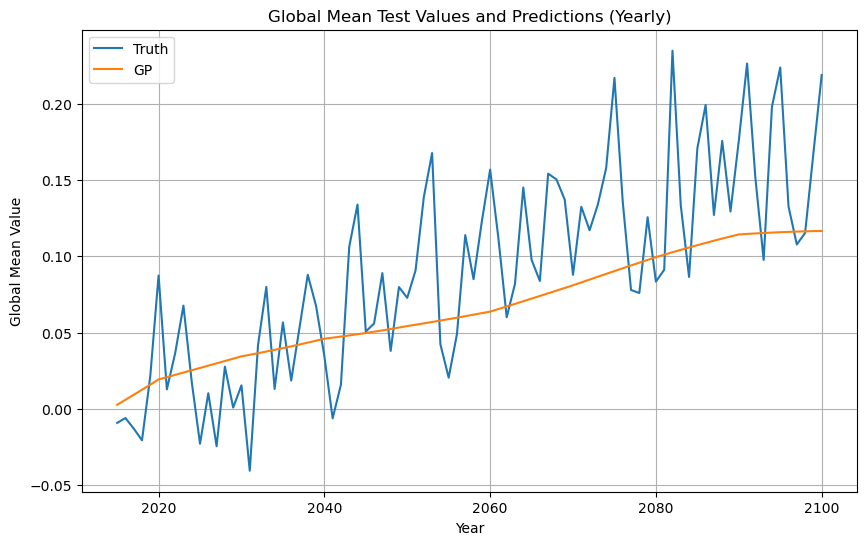

In [58]:
plt.figure(figsize=(10, 6))
global_mean(pr_truth).plot(label="Truth")
global_mean(mean_best).plot(label='GP')
plt.title('Global Mean Test Values and Predictions (Yearly)')
plt.ylabel('Global Mean Value')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

[Text(0.5, 1.0, 'Difference')]

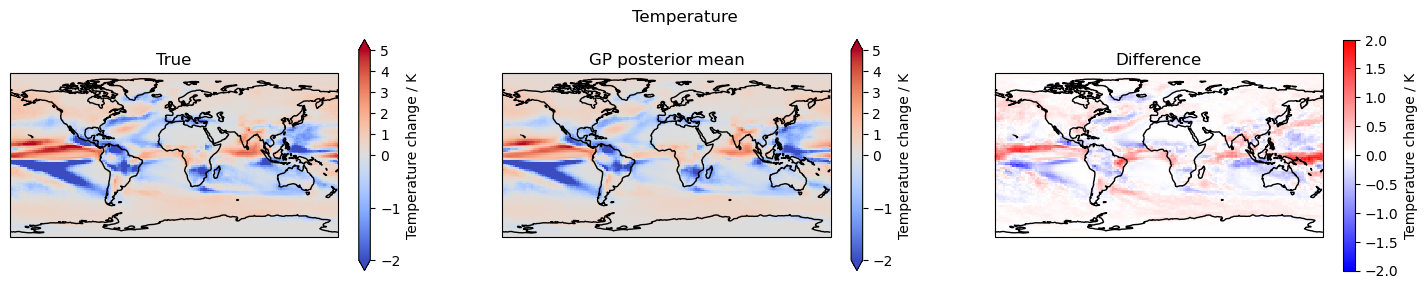

In [59]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
pr_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
mean_best.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr_truth - mean_best
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [60]:
TNRMSE(pr_truth, mean_best, Yearslice=slice(2080, 2100))

4.558

In [61]:
mean_best.to_netcdf('results/Final-dkl-mean-pr90.nc')
std_best.to_netcdf('results/Final-dkl-std-pr90.nc')

In [62]:
best_config.config

{'activation': 'sigmoid',
 'bnorm': False,
 'dropout': True,
 'dropout_prob': 0.5,
 'kernel_types': ('SquaredExponential',
  'SquaredExponential',
  'SquaredExponential',
  'SquaredExponential'),
 'active_dim_multiplier': 1,
 'dim_max': 128,
 'output_dim': 12,
 'optimizer_lr': 0.01}